# Query optimization of relational algebra in Python.

Copyright Jens Dittrich & Felix Martin Schuhknecht & Marcel Maltry [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Rule-based Optimization

### Imports and Setup

In [1]:
from graphviz import Digraph, Source
from ra.relation import Relation
from ra.schema_utils import build_schema
from ra.operators_log import *
from ra.operators_phys_relation import *
from ra.rule import *
from ra.rules_log import *
from ra.rules_phys import *
import re
import copy

In [2]:
from os import listdir

# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

path = 'data/IMDb_sample'  
# create a list of all files in that directory that end with "*.csv":
files = [file for file in listdir(path) if file.endswith('.csv')]

from ra.csv_utils import load_csv

relations = [load_csv(path + '/' + file, file[:-4], delimiter='\t') for file in files]

relationsDict = {}
for rel in relations:
    relationsDict[rel.name] = rel
print(relationsDict)

{'movies_directors': <ra.relation.Relation object at 0x10ecf1208>, 'actors': <ra.relation.Relation object at 0x10ecf12e8>, 'directors': <ra.relation.Relation object at 0x10c83e240>, 'movies_genres': <ra.relation.Relation object at 0x10c83e550>, 'directors_genres': <ra.relation.Relation object at 0x10ed37198>, 'movies': <ra.relation.Relation object at 0x10ed378d0>, 'roles': <ra.relation.Relation object at 0x10ed37828>}


In [3]:
# build LeafRelation object from relations dictionary
movies_directors = LeafRelation(relationsDict['movies_directors'])
actors = LeafRelation(relationsDict['actors'])
directors = LeafRelation(relationsDict['directors'])
movies_genres = LeafRelation(relationsDict['movies_genres'])
directors_genres = LeafRelation(relationsDict['directors_genres'])
movies = LeafRelation(relationsDict['movies'])
roles = LeafRelation(relationsDict['roles'])

In [4]:
# build indexes
directors_genres.relation.build_index('genre')
directors_genres.relation.build_index('prob')

### Example

An example for an unoptimized logical operator tree:

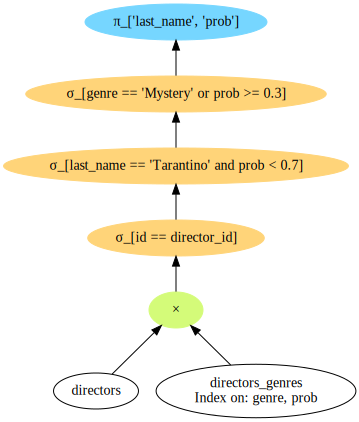

In [5]:
# Unoptimized plan
cp = Cartesian_Product(directors, directors_genres)
sel1 = Selection(cp, "id == director_id")
sel2 = Selection(sel1, "last_name == 'Tarantino' and prob < 0.7")
sel3 = Selection(sel2, "genre == 'Mystery' or prob >= 0.3")
proj = Projection(sel3, ['last_name', 'prob'])

graph = proj.get_graph()
Source(graph)

### Optimization 1: Break up 'and' selections

Replace every selection of the form (A and B and C) with a chain of individual selections of the form (A), (B), (C). This optimization enables a fine-granular selection pushdown (Optimization 2).

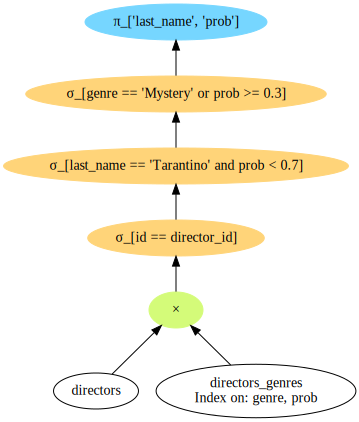

In [6]:
# before optimization
graph = proj.get_graph()
Source(graph)

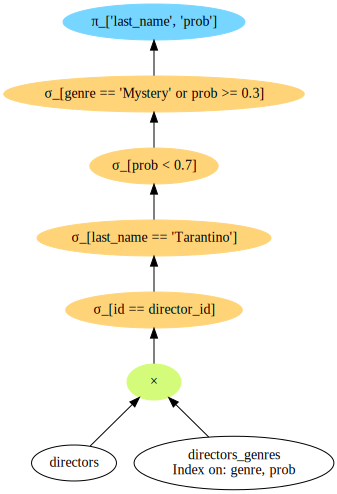

In [7]:
bus = BreakUpSelections(proj) 
bus.optimize(proj)

# after optimization
graph = bus.root.get_graph()
Source(graph)

### Optimization 2: Push down selections

Push down every selection as far as possible in the operator tree. This assures the early elimination of tuples. We assume that optimization 1 has been applied already.

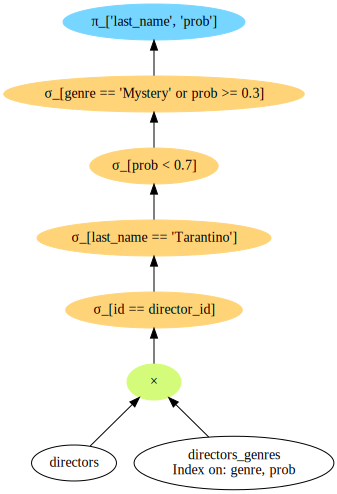

In [8]:
# before optimization
graph = bus.root.get_graph()
Source(graph)

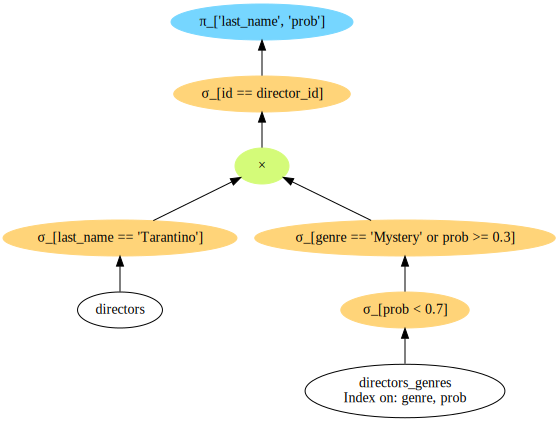

In [9]:
pds = PushDownSelection(bus.root) 
pds.optimize(bus.root)

# after optimization
graph = pds.root.get_graph()
Source(graph)

### Optimization 3: Replace a join-style selection on top of a cartesian product by a theta join 

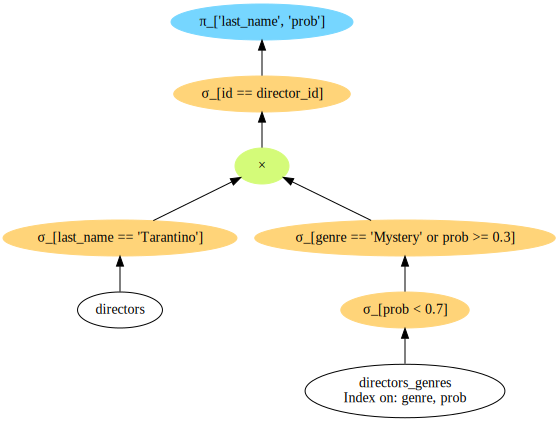

In [10]:
# before optimization
graph = pds.root.get_graph()
Source(graph)

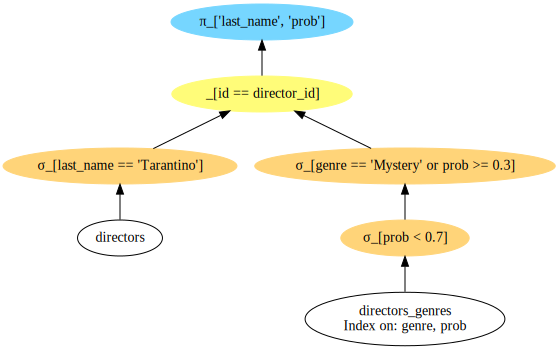

In [11]:
rbj = ReplaceByJoin(pds.root) 
rbj.optimize(pds.root)

# after optimization
graph = rbj.root.get_graph()
Source(graph)

### Optimization 4: Insert projections

Project only the attributes, that are needed upwards the tree

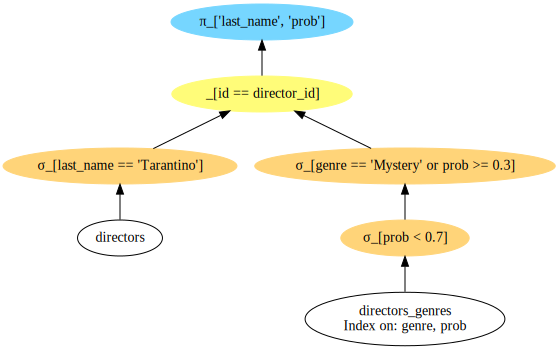

In [12]:
# before optimization
graph = rbj.root.get_graph()
Source(graph)

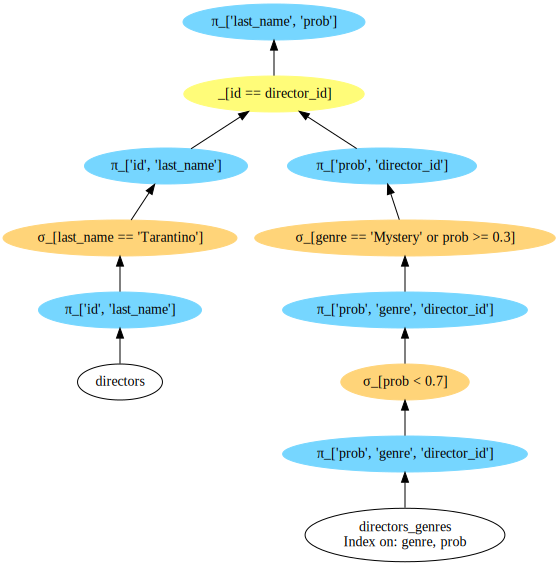

In [13]:
ip = InsertProjection(rbj.root) 
ip.optimize(rbj.root)

# after optimization
graph = ip.root.get_graph()
Source(graph)

### Exercise: Break up 'Or' Selections

Replace every selection of the form (A or B or C) with a chain of unions (A) union (B) union (C). For example:

You have to translate a tree like the following ...

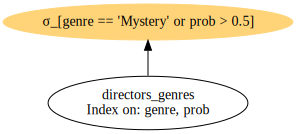

In [14]:
ex_sel = Selection(directors_genres, "genre == 'Mystery' or prob > 0.5")
graph = ex_sel.get_graph()
Source(graph)

... into a tree like:

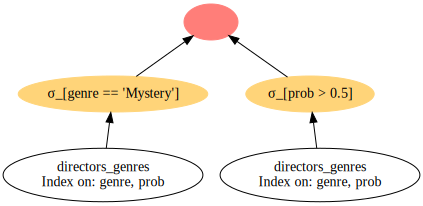

In [15]:
ex_sel1 = Selection(directors_genres, "genre == 'Mystery'")
ex_sel2 = Selection(directors_genres, "prob > 0.5")
ex_union = SetOperator(ex_sel1, ex_sel2, operator.or_, "∪")
graph = ex_union.get_graph()
Source(graph)

Your implementation should be able to handle multiple 'or' in a selection as well as arbitrarily complex subtrees below the selection. 

In [16]:
class BreakUpOrSelections(Rule):
    """"BreakUpOrSelections Class

    Note:
        Breaks up selections, where the predicates are concatenated via 'or'.
    """
    def __init__(self, root):
        super().__init__(root)
        
    def _is_or_selection(self, op):
        # ... check whether it is a compound selection
        # Note: for simplicity, we assume predicates of the form 'A op x or B op y or C op z or ...' 
        # and reject anything else 
        
        # if there are any brackets, reject directly
        brackets = r'()'
        if(any(elem in op.predicate for elem in brackets)):
            return False
        
        # first split by ' and '
        subpredicates = op.predicate.split(' or ')
        if(len(subpredicates) < 2):
            return False
        
        comp_operators = ['==', '<=', '<', '>', '>=']
        for s in subpredicates:
            # next, split by comparison operator
            for o in comp_operators:
                if(o in s):
                    splits = s.split(o)
                    if(len(splits) != 2):
                        # we should get 2 expression, but we don't, so reject selection
                        return False
        return True
    
    def _match(self, op, parent):
        # For each selection operator found ...
        if(isinstance(op, Selection)):            
            # ... check whether it is an 'or' selection
            return self._is_or_selection(op)

    def _modify(self, op, parent):
        """
        Splits up a selection with multiple predicates connected via OR into individual selection
        connected via Union.
        
        Args:
            op (:obj: Operator): the operator that has been matched
            parent (:obj: Operator): the direct parent of op 
        
        Returns:
            cont_op (:obj: Operator): the operator to continue matching or None, if optimzation should terminate
            cont_parent (:obj: Operator): the parent of the operator to continue matching
        """
        # add your code here!
        # ...
        # Feel free to use self._copy_tree(), self.__split_or_selection, and Rule._replace()
        return None, None
    
    def _copy_tree(self, op):
        copy_op = copy.copy(op)
        if(isinstance(op, UnaryOperator)):
            copy_op.input = self._copy_tree(op.input)
        elif(isinstance(op, BinaryOperator)):
            copy_op.l_input = self._copy_tree(op.l_input)
            copy_op.r_input = self._copy_tree(op.r_input)
        return copy_op
    
    def _split_or_selection(self, op):
        """Splits an 'and' compound selection

        Args:
            op (:obj: Operator): The compound selection to split
            
        Returns:
            The chain of Selection objects, represting the split selection
        """
        # split the predicate
        predicates = op.predicate.split(' or ')
        selections = []
        # build the selection chain bottom up
        sel = op.input
        for p in predicates:
            sel = Selection(sel, p)
            selections.append(sel)
            
        return selections

#### Testing

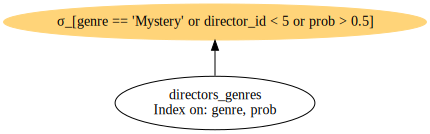

In [17]:
# before optimization
test_sel = Selection(directors_genres, "genre == 'Mystery' or director_id < 5 or prob > 0.5")
graph = test_sel.get_graph()
Source(graph)

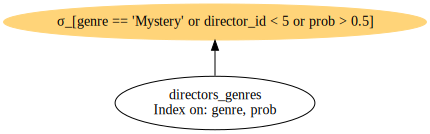

In [18]:
test_or = BreakUpOrSelections(test_sel) 
test_or.optimize(test_sel)

# after optimization
graph = test_or.root.get_graph()
Source(graph)

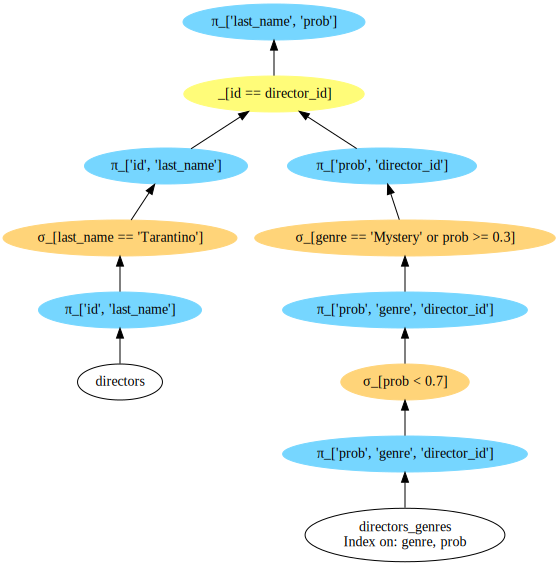

In [19]:
bup_or = BreakUpOrSelections(ip.root) 
bup_or.optimize(ip.root)

# after optimization
graph = bup_or.root.get_graph()
Source(graph)

## Query Compilation

In [20]:
physical_plan = compile_plan(bup_or.root)

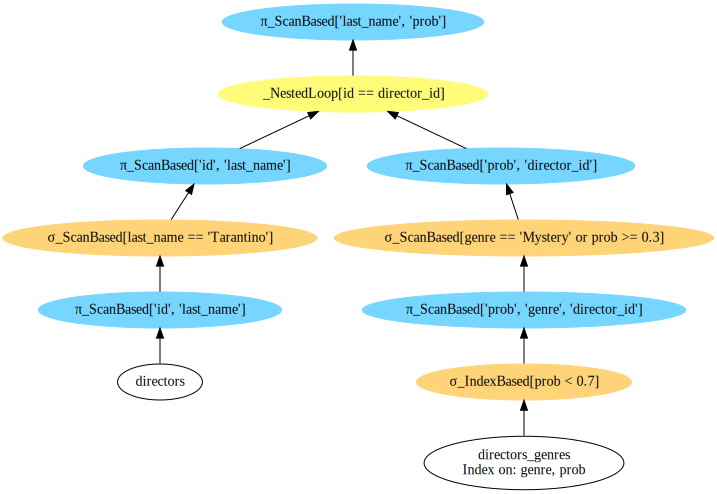

In [21]:
graph = physical_plan.get_graph()
Source(graph)

In [22]:
physical_plan.evaluate().print_set()

[Result] : {[ last_name:str, prob:float ]}
{
	(Tarantino, 0.5),
	(Tarantino, 0.125)
}
